In [1]:
import jax
import math

import numpy as onp
from jax import numpy as jnp
from matplotlib import pyplot as plt
import tensorflow as tf
# from tensorflow_probability.substrates import jax as tfp
# tfd = tfp.distributions

%matplotlib inline

## MNIST

In [3]:
x_train = onp.loadtxt("mnist_train_x.csv")
y_train = onp.loadtxt("mnist_train_y.csv")
x_test = onp.loadtxt("mnist_test_x.csv")
y_test = onp.loadtxt("mnist_test_y.csv")

In [4]:
n_data, n_features = x_train.shape
print("Data shape: ({}, {})".format(n_data, n_features))

Data shape: (60000, 784)


In [5]:
# x_train = x_train.reshape((n_data, 28, 28, 1))

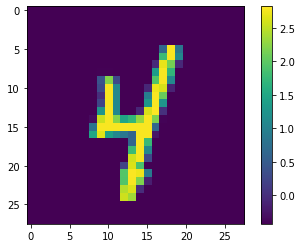

In [6]:
plt.imshow(x_train[0].reshape(28, 28))
plt.colorbar()

In [7]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

## Model and Losses

In [8]:
import jax_models as models

In [50]:
net_apply, net_init = models.get_model("mlp_classification", data_info={"num_classes": 10})
prior_variance = 1.


def log_likelihood_fn(params, net_state, batch, is_training=True):
    """Computes the log-likelihood."""
    x, y = batch
    logits, net_state = net_apply(params, net_state, None, x, is_training)
    num_classes = logits.shape[-1]
    labels = jax.nn.one_hot(y, num_classes)
    softmax_xent = jnp.sum(labels * jax.nn.log_softmax(logits))

    return softmax_xent, net_state


def log_prior_fn(params):
    """Computes the Gaussian prior log-density."""
    n_params = sum([p.size for p in jax.tree_leaves(params)])
    exp_term = sum(jax.tree_leaves(jax.tree_map(
        lambda p: (-p**2 / (2 * prior_variance)).sum(), params)))
    norm_constant = -0.5 * n_params * jnp.log((2 * math.pi * prior_variance))
    return exp_term + norm_constant


def log_posterior_fn(params, net_state, batch, is_training=True):
    log_lik, net_state = log_likelihood_fn(params, net_state, batch, is_training=True)
    log_prior = log_prior_fn(params) * 0
    return log_lik + log_prior, net_state


@jax.jit
def get_accuracy_fn(batch, params, net_state):
    x, y = batch
    logits, _ = net_apply(params, net_state, None, x, False)
    preds = jnp.argmax(logits, axis=1)
    accuracy = (preds == y).mean()
    return accuracy


def evaluate_fn(dataset, params, net_state):
    sum_accuracy = 0
    for x, y in dataset:
        x, y = jnp.asarray(x), jnp.asarray(y)
        batch_accuracy = get_accuracy_fn((x, y), params, net_state)
        sum_accuracy += batch_accuracy.item()
    return sum_accuracy / len(dataset)


log_posterior_wgrad_fn = jax.jit(jax.value_and_grad(log_posterior_fn, argnums=0, has_aux=True))

In [63]:
seed = jax.random.PRNGKey(0)
key, net_init_key = jax.random.split(seed, 2)
init_data, _ = next(iter(train_dataset))
init_data = jnp.asarray(init_data)
params, net_state = net_init(net_init_key, init_data, True)

## Training

In [64]:
import optax

In [65]:
batch_size = 100
test_batch_size = 1000
num_epochs = 20
shuffle_buffer_size = 1000
momentum_decay = 0.9
init_lr = 1.e-3

train_dataset_batched = train_dataset.shuffle(shuffle_buffer_size, reshuffle_each_iteration=True)
train_dataset_batched = train_dataset_batched.batch(batch_size)
test_dataset_batched = test_dataset.batch(test_batch_size)

epoch_steps = len(train_dataset_batched)
total_steps = epoch_steps * num_epochs



def lr_schedule(step):
    t = step / total_steps
    return 0.5 * init_lr * (1 + jnp.cos(t * onp.pi))

optimizer = optax.chain(
    optax.trace(decay=momentum_decay, nesterov=False),
    optax.scale_by_schedule(lr_schedule))
opt_state = optimizer.init(params)

In [66]:
for epoch in range(num_epochs):
    sum_loss = 0.
    for x, y in train_dataset_batched:
        x, y = jnp.asarray(x), jnp.asarray(y)
        (loss, net_state), grad = log_posterior_wgrad_fn(params, net_state, (x, y))
        updates, opt_state = optimizer.update(grad, opt_state)
        params = optax.apply_updates(params, updates)
        sum_loss += loss.item()
    
    test_acc = evaluate_fn(test_dataset_batched, params, net_state)
    print("Epoch {}".format(epoch))
    print("\tAverage loss: {}".format(sum_loss / epoch_steps))
    print("\tTest accuracy: {}".format(test_acc))

Epoch 0
	Average loss: -23.642967890898387
	Test accuracy: 0.9597000420093537
Epoch 1
	Average loss: -11.191662452121575
	Test accuracy: 0.9658000409603119
Epoch 2
	Average loss: -8.477553930381934
	Test accuracy: 0.9688000500202179
Epoch 3
	Average loss: -6.262596315816045
	Test accuracy: 0.9729000568389893
Epoch 4
	Average loss: -4.609476787646612
	Test accuracy: 0.9755000472068787
Epoch 5
	Average loss: -3.40231042525731
	Test accuracy: 0.9757000505924225
Epoch 6
	Average loss: -2.3744151169321657
	Test accuracy: 0.9807000458240509
Epoch 7
	Average loss: -1.2334694972642077
	Test accuracy: 0.9793000459671021
Epoch 8
	Average loss: -0.8837937871395843
	Test accuracy: 0.9818000376224518
Epoch 9
	Average loss: -0.4168170049598363
	Test accuracy: 0.9827000439167023
Epoch 10
	Average loss: -0.1246991726004247
	Test accuracy: 0.9837000429630279
Epoch 11
	Average loss: -0.060040685261119504
	Test accuracy: 0.9837000489234924
Epoch 12
	Average loss: -0.02978345209218484
	Test accuracy: 0.98

In [14]:
(loss, net_state), grad = log_posterior_wgrad_fn(params, net_state, (x, y))

In [15]:
updates, opt_state = optimizer.update(grad, opt_state)
params = optax.apply_updates(params, updates)

In [17]:
loss.item()

-247932.765625

In [ ]:
x.shape

In [ ]:
for epoch in range(100)